#Task: DeepLense (Test 1)
#Author: Archil Srivastava

### Table of Contents
* [Imports](#imports)
* [Prepare Dataset](#prepare-dataset)
    * [Load Dataset](#load-dataset)
    * [Analyse Dataset](#analyse-dataset)
    * [Preprocess Dataset](#preprocess-dataset)
* [Training Pipeline](#train-pipeline)
* [Training](#training)
* [Evaluation](#evaluation)
    * [External Evaluation](#external-evaluation)
* [Acknowledgements](#acknowledgements)

<a name="imports"></a>
# Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import (Layer, Input, Flatten,
                          Conv2D, MaxPool2D,
                          BatchNormalization, Dense, Dropout,
                          RandomFlip, RandomRotation, RandomZoom)
from keras import layers

import numpy as np
import matplotlib.pyplot as plot

import os
import warnings
import pdb

In [3]:
### Set Numpy Print Options ###
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [4]:
### Set random seed for reproducibility ###
SEED = 1
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [5]:
PERFORM_TRAINING = False # Set to False if only inference is to be done

<a name="prepare-dataset"></a>
# Prepare Dataset

<a name="load-dataset"></a>
### Load Dataset

In [6]:
DATAPATH = './data'
OUTPATH = './output' # Storing output
os.makedirs(OUTPATH, exist_ok=True)
SAVEPATH = os.path.join(OUTPATH, 'weights') # For storing model weights
os.makedirs(SAVEPATH)
CKP_PATH = os.path.join(SAVEPATH, 'ckp')

CATEGORIES = ('no', 'sphere', 'vort') # Labels: no=0, sphere=1, vort=2

In [7]:
# Unzip data
!unzip -oq ./drive/MyDrive/test_1 -d {DATAPATH}; mv {DATAPATH}/dataset/* {DATAPATH}; rm -rf {DATAPATH}/dataset

In [ ]:
# Unzip model weights (if available)
!unzip -oq {os.path.join(OUTPATH, 'test_1_weights.zip')} -d {OUTPATH}

In [8]:
# Print directory structure
!tree --filelimit=10

.
├── data
│   ├── __MACOSX
│   │   └── dataset
│   │       ├── train
│   │       └── val
│   ├── train
│   │   ├── no [10000 entries exceeds filelimit, not opening dir]
│   │   ├── sphere [10000 entries exceeds filelimit, not opening dir]
│   │   └── vort [10000 entries exceeds filelimit, not opening dir]
│   └── val
│       ├── no [2500 entries exceeds filelimit, not opening dir]
│       ├── sphere [2500 entries exceeds filelimit, not opening dir]
│       └── vort [2500 entries exceeds filelimit, not opening dir]
└── output
    └── weights

15 directories, 0 files


In [9]:
def load_data(root, datatype, categories, use_cached=True):
    if use_cached:
        try:
            x = np.load(os.path.join(root, f'X_{datatype}.npy'))
            y = np.load(os.path.join(root, f'Y_{datatype}.npy'))
            return x, y
        except FileNotFoundError as _:
            warnings.warn('Cached data does not exist! Loading from raw data.')

    x, y = [], []
    num_classes = len(categories)
    for index, category in enumerate(categories):
        category_path = os.path.join(root, datatype, category)
        for filename in os.scandir(category_path):
            # Load data
            filedata = np.load(filename.path)
            x.append(filedata)

            # Load label (Convert into onehot)
            label = np.stack([np.eye(num_classes)[index]
                              for _ in range(len(filedata))], axis=0)
            y.append(label)
    x = np.expand_dims(np.concatenate(x, axis=0), axis=-1) # add channel axis
    y = np.concatenate(y, axis=0)

    # Save
    np.save(os.path.join(root, f'X_{datatype}.npy'), x)
    np.save(os.path.join(root, f'Y_{datatype}.npy'), y)

    return x, y

In [10]:
X_TRAIN, Y_TRAIN = load_data(DATAPATH, 'train', CATEGORIES, use_cached=True)
print(f'Shape of X_TRAIN: {X_TRAIN.shape}')
print(f'Shape of Y_TRAIN: {Y_TRAIN.shape}')

X_VAL, Y_VAL = load_data(DATAPATH, 'val', CATEGORIES, use_cached=True)
print(f'Shape of X_VAL: {X_VAL.shape}')
print(f'Shape of Y_VAL: {Y_VAL.shape}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Cached data does not exist! Loading from raw data.
  


Shape of X_TRAIN: (30000, 150, 150, 1)
Shape of Y_TRAIN: (30000, 3)
Shape of X_VAL: (7500, 150, 150, 1)
Shape of Y_VAL: (7500, 3)


<a name="analyse-dataset"></a>
### Analyse Dataset

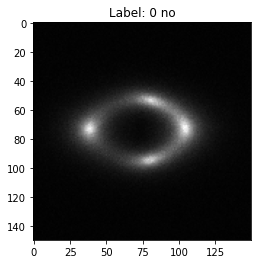

In [11]:
# Display random instance of data (This won't affect original SEED progression)
idx = np.random.default_rng().integers(0, len(X_TRAIN))
_ = plot.imshow(X_TRAIN[idx].squeeze(), cmap='gray')
label = np.argmax(Y_TRAIN[idx])
_ = plot.title(f'Label: {label} {CATEGORIES[label]}')

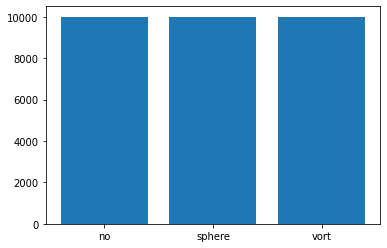

In [12]:
# Check for class imbalance in train set
labels = np.argmax(Y_TRAIN, axis=1)
class_sizes = [len(labels[labels == idx]) for idx in range(len(CATEGORIES))]

fig, axis = plot.subplots()
_ = axis.bar(range(len(CATEGORIES)), class_sizes, tick_label=CATEGORIES)

<a name="preprocess-dataset"></a>
### Preprocess Dataset

In [13]:
def standardize(x, datatype, root):
    '''Standardize image examples'''
    # Make image contrast similar across all images
    x = ((x - np.mean(x, axis=(1, 2), keepdims=True)) /
         np.std(x, axis=(1, 2), keepdims=True))
    return x

In [14]:
### Preprocess data ###

# Shuffle train data
perm = np.random.permutation(len(X_TRAIN))
X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

# Standardize data
X_TRAIN = standardize(X_TRAIN, 'train', OUTPATH)
X_VAL = standardize(X_VAL, 'val', OUTPATH)

<a name="train-pipeline"></a>
# Training Pipeline

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Augmentation
    x = keras.Sequential([layers.RandomFlip(),
                          layers.RandomRotation(0.5),
                          RandomZoom(height_factor=0.2, width_factor=0.2)
                        ], name='augment')(inputs)

    # Conv Block 1
    x = layers.Conv2D(16, 5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Conv Block 2, 3, 4
    for _ in range(3):
        x = layers.Conv2D(32, 3)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPool2D()(x)

    # Conv Block 5, 6
    for _ in range(2):
        residual = layers.Conv2D(64, 1)(x)
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.add([x, residual]) # Residual connection


    # Conv Block 7
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Flatten()(x)

    # Feed Forward Network
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Classifier
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

<a name="training"></a>
# Training

In [16]:
class RandomSampleGenerator(keras.utils.Sequence):
    '''
    Generates batches containing equal number of positive and negative examples
    to rectify any class imbalance in data
    '''
    def __init__(self, x, y, batch_size, seed=None):
        self.labels = np.argmax(y, axis=1)
        self.classes = np.unique(labels)
        self.x = [x[labels == class_] for class_ in self.classes]
        self.y = [y[labels == class_] for class_ in self.classes]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        # Reset random number generator
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):
        batch_x, batch_y = [], []
        num_classes = len(self.classes)
        for class_ in range(num_classes):
            indices = self.rng.choice(self.x[class_].shape[0],
                                      self.batch_size // num_classes,
                                      replace=False)
            batch_x.append(self.x[class_][indices])
            batch_y.append(self.y[class_][indices])

        # Concat all samples
        batch_x = np.concatenate(batch_x)
        batch_y = np.concatenate(batch_y)

        return batch_x, batch_y


In [17]:
class TrackBestPerformance(keras.callbacks.Callback):
    '''
    Callback to keep track of model weights which give best val_auc
    After training completes, the model is assigned with the best model weights
    '''
    def __init__(self, ckp_path, save_every=15, **kwargs):
        super().__init__(**kwargs)
        self.best_auc = 0
        self.best_epoch = -1
        self.best_weights = None
        self.ckp_path = ckp_path
        self.save_every = save_every
  
    def on_epoch_end(self, epoch, logs=None):
        '''Track best val_auc and corresponding weights'''
        current_auc = logs['val_auc']
        if current_auc >= self.best_auc:
            self.best_auc = current_auc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
        if epoch % self.save_every == 0:
            self.model.save_weights(self.ckp_path)
  
    def on_train_end(self, logs=None):
        '''Reassign model weights to the one with the best val_auc'''
        self.model.set_weights(self.best_weights)
        self.model.save_weights(self.ckp_path)
        print(f'\nBest validation AUC is {self.best_auc} '
              f'on epoch #{self.best_epoch + 1}')


In [18]:
BATCH_SIZE = 256
EPOCHS = 300
LEARNING_RATE = 5e-4

# Pick a pre-saved model to finetune further
USE_SAVED_MODEL = False

# Run eagerly for debugging
RUN_EAGERLY = False

In [19]:
# Instantiate new model
model = make_model(X_TRAIN.shape[1:], len(CATEGORIES))

model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=keras.metrics.AUC(multi_label=True, num_labels=3, name='auc'), # AUC is average of the AUCs from the multiclass labels
              run_eagerly=RUN_EAGERLY)

if USE_SAVED_MODEL:
    # Pick a pre-trained model to finetune
    model.load_weights(CKP_PATH)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 augment (Sequential)           (None, 150, 150, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 146, 146, 16  416         ['augment[0][0]']                
                                )                                                                 
                                                                                              

In [21]:
if PERFORM_TRAINING:
    data_generator = RandomSampleGenerator(X_TRAIN, Y_TRAIN,
                                        batch_size=BATCH_SIZE, seed=SEED)
    callbacks = [TrackBestPerformance(CKP_PATH)]

    history = model.fit(data_generator, validation_data=(X_VAL, Y_VAL),
                        epochs=EPOCHS, callbacks=callbacks, verbose=2)
else:
    model.load_weights(CKP_PATH)

Epoch 1/300
117/117 - 59s - loss: 1.2363 - auc: 0.5060 - val_loss: 1.1002 - val_auc: 0.5053 - 59s/epoch - 505ms/step
Epoch 2/300
117/117 - 43s - loss: 1.1266 - auc: 0.5119 - val_loss: 1.1093 - val_auc: 0.5089 - 43s/epoch - 368ms/step
Epoch 3/300
117/117 - 44s - loss: 1.1170 - auc: 0.5151 - val_loss: 1.1060 - val_auc: 0.5241 - 44s/epoch - 378ms/step
Epoch 4/300
117/117 - 45s - loss: 1.0993 - auc: 0.5308 - val_loss: 1.1210 - val_auc: 0.5481 - 45s/epoch - 387ms/step
Epoch 5/300
117/117 - 46s - loss: 1.0875 - auc: 0.5638 - val_loss: 1.1213 - val_auc: 0.5937 - 46s/epoch - 394ms/step
Epoch 6/300
117/117 - 46s - loss: 1.0089 - auc: 0.6624 - val_loss: 1.2156 - val_auc: 0.6763 - 46s/epoch - 393ms/step
Epoch 7/300
117/117 - 46s - loss: 0.9350 - auc: 0.7174 - val_loss: 1.8872 - val_auc: 0.6412 - 46s/epoch - 394ms/step
Epoch 8/300
117/117 - 46s - loss: 0.8656 - auc: 0.7626 - val_loss: 1.3205 - val_auc: 0.6882 - 46s/epoch - 394ms/step
Epoch 9/300
117/117 - 46s - loss: 0.8328 - auc: 0.7816 - val_los

In [22]:
if PERFORM_TRAINING:
    best_epoch_idx = np.argmax(history.history['val_auc'])

    print('Best validation AUC: {:.2%}'.format(history.history['val_auc'][best_epoch_idx]))
    print('Corresponding train AUC: {:.2%}'.format(history.history['auc'][best_epoch_idx]))

Best validation AUC: 99.29%
Corresponding train AUC: 99.36%


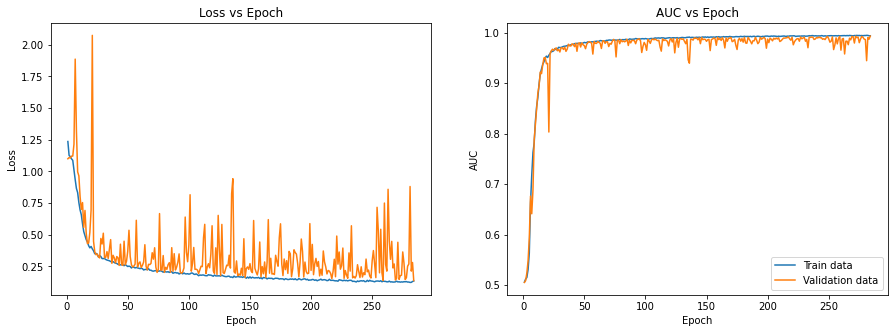

In [23]:
if PERFORM_TRAINING:
    _, axes = plot.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Loss vs Epoch plot
    _ = axes[0].plot(range(1, best_epoch_idx + 2),
                     history.history['loss'][:best_epoch_idx + 1],
                     label='Train data')
    _ = axes[0].plot(range(1, best_epoch_idx + 2),
                     history.history['val_loss'][:best_epoch_idx + 1],
                     label='Validation data')
    _ = axes[0].set(xlabel='Epoch', ylabel='Loss', title='Loss vs Epoch')

    # AUC vs Epoch plot
    _ = axes[1].plot(range(1, best_epoch_idx + 2),
                     history.history['auc'][:best_epoch_idx + 1],
                     label='Train data')
    _ = axes[1].plot(range(1, best_epoch_idx + 2),
                     history.history['val_auc'][:best_epoch_idx + 1],
                     label='Validation data')
    _ = axes[1].set(xlabel='Epoch', ylabel='AUC', title='AUC vs Epoch')

    _ = plot.legend()

In [24]:
# Zip model weights for download
!pushd {OUTPATH}; zip -rq test_1_weights.zip weights; popd

/content/output /content
/content


<a name="evaluation"><a/>
# Evaluation

In [25]:
def split_and_predict(x, num_batches=50):
    '''
    Utility function to do a forward pass with large data
    Splits data into batches and does forward pass through the model
    '''
    x_batches = np.array_split(x, num_batches)
    y_pred = np.concatenate([model(x_batch).numpy() for x_batch in x_batches], axis=0)
    return y_pred

In [26]:
# Get predictions (needed for plotting ROC curve)
Y_PRED_TRAIN = split_and_predict(X_TRAIN)
Y_PRED_VAL = split_and_predict(X_VAL)

In [27]:
def plot_roc_curve(y, y_pred, categories, axis, num_thresholds=200):
    thresholds = np.linspace(0., 1., num_thresholds)

    tp, fp, tn, fn = [], [], [], []

    for threshold in thresholds:
        y_pred_label = (y_pred > threshold).astype(int)
        tp.append(np.count_nonzero(((y_pred_label == 1) & (y == 1)), axis=0))
        fp.append(np.count_nonzero(((y_pred_label == 1) & (y == 0)), axis=0))
        tn.append(np.count_nonzero(((y_pred_label == 0) & (y == 0)), axis=0))
        fn.append(np.count_nonzero(((y_pred_label == 0) & (y == 1)), axis=0))

    tp, fp, tn, fn = np.array(tp), np.array(fp), np.array(tn), np.array(fn)

    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)

    for idx, category in enumerate(categories):
        _ = axis.plot(fp_rate[:, idx], tp_rate[:, idx], label=category)

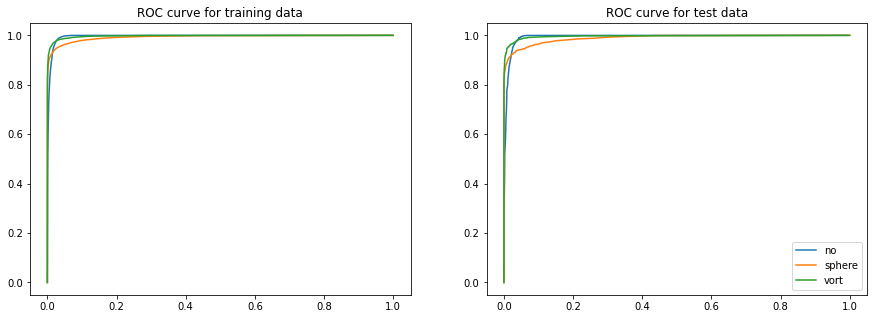

In [28]:
fig, axes = plot.subplots(nrows=1, ncols=2, figsize=(15, 5))

plot_roc_curve(Y_TRAIN, Y_PRED_TRAIN, CATEGORIES, axes[0])
_ = axes[0].set(title='ROC curve for training data')

plot_roc_curve(Y_VAL, Y_PRED_VAL, CATEGORIES, axes[1])
_ = axes[1].set(title='ROC curve for test data')

_ = plot.legend()

<a name="external-evaluation"><a/>
### External Evaluation

In [ ]:
# Load test data | Shape: (None, 150, 150, 1)
X_TEST, Y_TEST = None, None

In [ ]:
# Standardize test data
X_TEST = standardize(X_TEST, 'test', OUTPATH)

# Calculate AUC
test_auc = model.evaluate(X_TEST, Y_TEST, verbose=0)[1]

print(f'AUC on test data is {test_auc}')

In [ ]:
# Get predictions (needed to plot ROC curve)
Y_PRED_TEST = split_and_predict(X_TEST)

In [ ]:
# Plot ROC curve
fig, axis = plot.subplots(figsize=(15, 5))

# ROC curve on train data
plot_roc_curve(Y_TEST, Y_PRED_TEST, CATEGORIES, axis)
_ = axis.set(title='ROC curve for test data')

_ = plot.legend()

<a name="acknowledgements"></a>

# Acknowledgements

The structure of the model used was partially inspired from the paper titled:

[Deep Convolutional Neural Networks as strong gravitational lens detectors](https://arxiv.org/pdf/1705.07132.pdf) by C. Schaefer, M. Geiger, T. Kuntzer, J-P. Kneib